画像に足しして色がついたり、消えたりする(？？)のが不気味すぎるので理由確認!!
全体的順序>　
1　hdf5から多次元配列を取り出す。
2　0秒目の画像を確認する。
3  一つの画像に対して平坦化処理をかける
4  連番画像を作る.
5  連番画像に平坦化処理をかける
6  平坦化した連番画像をmp4に変換する.
7  輝度を高さとした3Dplotの連番画像を作成する
8  3Dplotを連番

In [25]:
import cv2
import h5py
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import Image, display_png
from PIL import Image, ImageOps
from scipy import interpolate
from scipy.optimize import curve_fit

%matplotlib inline

h5ファイルの読み込み

In [9]:
h = r"Obj_1 - recording_20180410_093103-trim-preproc-mc.h5"

In [10]:
with h5py.File(h,'r') as f:
    # ファイルオブジェクトをイテレートするとファイル直下のオブジェクト名を返す
    for k in f:
        data = f['Object'][0]       


dataの次元確認

In [11]:
print(data.shape)
print(type(data[0][0][0]))

(1001, 355, 266)
<class 'numpy.uint16'>


In [12]:
data[0].shape

(355, 266)

jupyter上で表示:色がつく。黄色の強い所が輝度の高い部位

In [13]:
#plt.imshow(data[0])

pngとして0番目を保存。(デフォルトで上書きなので注意)

In [14]:
#型変換
data2= np.array(data,dtype=np.uint16)

In [30]:
#plt.imshow(data2[0])

In [28]:
#保存テスト
plt.imsave('test_test.png',data2[0]) 
data2[0].shape

(355, 266)

平坦化

In [32]:
img = cv2.imread('test_test.png',0)
img_equ = cv2.equalizeHist(img)
#plt.imshow(img_equ)
#plt.imsave("pilsave.png",img_equ)

ここまでで確認的な可視化。
以降は　平坦化　+　video化

ファイル名は上書きするので注意!!
👇は平坦化はしていない。

In [29]:
#タテ×ヨコ×数値の配列を画像へ変換#https://note.nkmk.me/python-numpy-image-processing/# print(data.dtype)# data = data.astype(np.uint8)

for i in range(data2.shape[0]):#1001回(time-frame)のイテラブル可能
    #i <-2次元×数値      
    w_path = r"E:\test_dir\test_test" + str(i) + ".png"
    plt.imsave(w_path,data2[i])
print("finsh!")

finsh!


平坦化したpngファイルを大量に作成する。

In [30]:
for j in range(data2.shape[0]):
    r_path = r"E:\test_dir\test_test" + str(j) + ".png"
    n_path = r"E:\test_dir\test_hist" + str(j) + ".png"
    
    img = cv2.imread(r_path,0)
    img_equ = cv2.equalizeHist(img)
    plt.imsave(n_path,img_equ)

print("eqalized!")

eqalized!


pngを結合して画像ファイルに変換する。

In [11]:
horizontal =  266
vertical   =  355
video_name = r"test_test"

In [31]:
fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video = cv2.VideoWriter('video.mp4', fourcc, 20, (horizontal,vertical))

for k in range(0, 1000):
    v_path = r"E:\test_dir\test_hist" +str(k) + r".png" 
    img = cv2.imread(v_path)
    img = cv2.resize(img,(horizontal,vertical))
    video.write(img)

video.release()

print("video made!")

ここまではh5から動画を作成する話。
以降はピクセルごとに光量変化を見る話.


In [22]:
def smooth(x,window_len=10,window='hanning'):

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

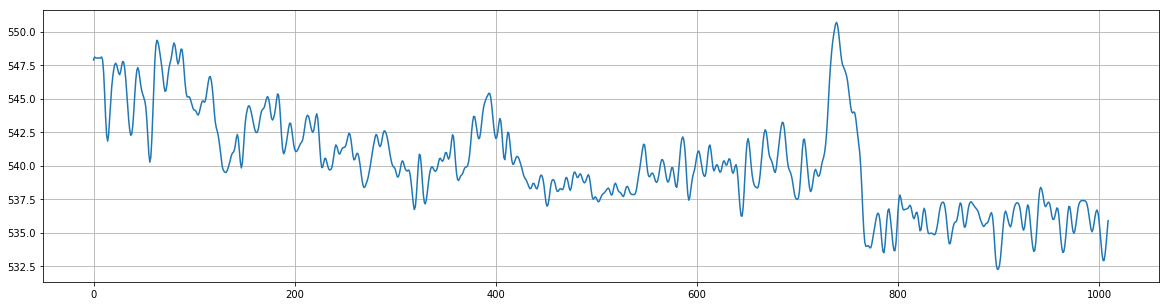

In [23]:
# 230,180 は明らかに光量が強いとわかっている場所。

y = smooth(data2[:,230,180])
x = [i for i in range(1010)]
f= interpolate.interp1d(x,y)


f = interpolate.interp1d(x, y, kind='nearest')
plt.figure(figsize=(20,5))
plt.plot(x, f(x),'-')
plt.grid(True)

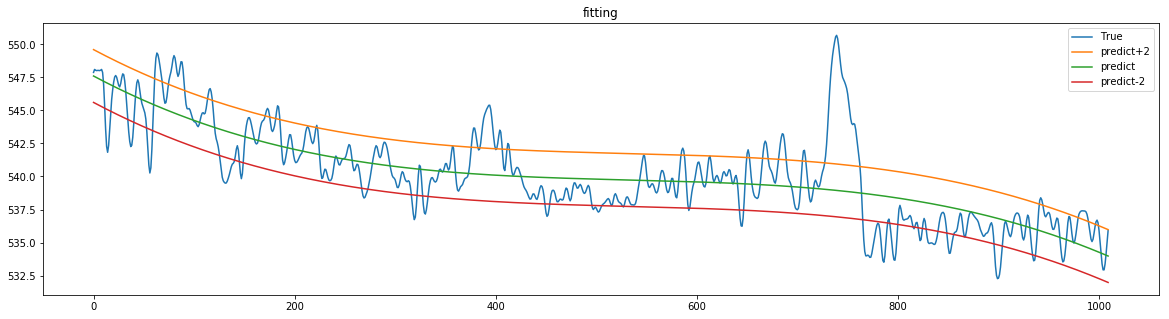

In [28]:
def linear_fit(x,a,b,c,d):
    return a* x * x *x + b*x*x + c*x + d

param, cov = curve_fit(linear_fit, x, y)

x = np.array(x, dtype=np.float64)
array_y_fit = param[0] * x *x *x + param[1] * x *x + param[2] *x + param[3]

plt.figure(figsize=(20, 5))
plt.plot(y)
plt.plot(array_y_fit+2)
plt.plot(array_y_fit)
plt.plot(array_y_fit-2)
plt.legend(['True','predict+2', 'predict', 'predict-2'])
plt.title("fitting")
plt.show()

ここまではピクセルごとに光量変化を見る話。
以降は動画の概観を得るために可視化する話。

In [19]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [ ]:
#http://jinpei0908.hatenablog.com/entry/2016/08/22/190951
#真似してるわけではない。👆参照程度

x = np.arange(0, 354, 1)
y = np.arange(0, 265, 1)
X, Y = np.meshgrid(x, y)
Z = data2[0][X,Y] 


fig = plt.figure(figsize = (15, 15))


ax = fig.add_subplot(2, 2, 1, projection = '3d', azim = 45)
ax.set_zlim(300,600)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap=cm.jet)

bx = fig.add_subplot(2, 2, 2, projection = '3d', azim = 135)
bx.set_zlim(300,600)
bx.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap=cm.jet)

cx = fig.add_subplot(2, 2, 3, projection = '3d', azim = -135)
cx.set_zlim(300,600)
cx.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap=cm.jet)

dx = fig.add_subplot(2, 2, 4, projection = '3d', azim = -45)
dx.set_zlim(300,600)
dx.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap=cm.jet)


#plt.show()

KeyboardInterrupt: 

#かなり時間がかかるので注意!!

In [ ]:
for i in range(0,1000): 
    d = data2[i,:,:] 
    x = np.arange(0, 354, 1)
    y = np.arange(0, 265, 1)
    X, Y = np.meshgrid(x, y)
    Z = d[X,Y]
    
    fig=plt.figure(figsize=(10,10))
    ax=fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap=cm.jet)

    plt.savefig("../datasets/figure" + str(i) + ".png")
    plt.close()


In [ ]:
x1 = np.arange(0, 354, 1)
y1 = np.arange(0, 265, 1)
X1, Y1 = np.meshgrid(x1, y1)

for t in range(0,1000):
    Z1 = data[t,X1,Y1] 
    fig=plt.figure(figsize=(10,10))
    ax=fig.add_subplot(111, projection='3d',azim=+135)
    ax.set_zlim(300,600)
    ax.plot_surface(X1, Y1, Z1, rstride=1, cstride=1,cmap=cm.jet)
    plt.savefig("3d_viewpoint_" + str(t) + ".png")